# Task 2: Data Sanitization

## Dependencies

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import os
import copy

### If you are using Google Colab, you need to upload this notebook and the codebase to your Google Drive. Then you need to mount your Google Drive in Colab and set your working directory. If you are running on your local machine, you can ignore the following line.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_dir = "/content/drive/My Drive/"
project_dir = "Assignment2" # Change to your path
os.chdir(root_dir + project_dir)

In [4]:
# Make sure the path is correct
!ls

 attack.py				    CS5562_Assignment_2_Warm_ups.ipynb
'Copy of CS5562_Assignment_2_Task2.ipynb'   dataset
'CS5562_Assignment_2_Task1 (1).ipynb'	    defense.py
 CS5562_Assignment_2_Task1.ipynb	    environment.yml
 CS5562_Assignment_2_Task2.ipynb	    model.py
 CS5562_Assignment_2_Task3.ipynb	    __pycache__
 CS5562_Assignment_2_Task4.ipynb	    utilities.py


## Implement data sanitizer

In [5]:
from utilities import *
import matplotlib.pyplot as plt

In [6]:
def data_sanitizer(training_data, estimate_eps):
    """
       Removes the estimate_eps fraction of points from X and Y.
    """

    n_est_poisoned = int(estimate_eps * len(training_data))

    #################
    # TODO: decide which points need to be deleted

    def calc_dist_to_centroid(training_data):
      class_map = {-1: 0, 1: 1}
      X = training_data.X
      Y = training_data.Y
      num_classes = len(set(Y))
      num_features = X.shape[1]

      centroids = np.zeros((num_classes, num_features))
      dis_to_centro = np.zeros(len(training_data))

      for y in set(Y):
          centroids[class_map[y], :] = np.median(X[Y == y, :], axis=0)

      for i in range(len(training_data)):
          dis_to_centro[i] = np.linalg.norm(X[i]-centroids[class_map[Y[i]]])

      return dis_to_centro

    def plot(dis_to_centro, name):
      # the histogram of the data
      min = np.min(dis_to_centro)
      max = np.max(dis_to_centro)
      bins = np.linspace(min, max, 100)

      plt.hist(dis_to_centro, bins, alpha=0.5, label='training data')
      plt.legend(loc='upper right')
      plt.title(name)
      plt.show()

    # Distances of whole training data
    distances = calc_dist_to_centroid(training_data)
    plot(distances, 'The distance to the centroid of the whole training data')

    # Distances after deletion
    index, ind1, ind2 = [], [], []
    threshold = 400
    values, counts = np.unique(distances, return_counts=True)
    count1_idx, count2_idx = np.argpartition(counts, -2)[-2:]

    if counts[count1_idx] > threshold:
      dist = values[count1_idx]
      ind1 = np.where(dist == distances)[0]

    if counts[count2_idx] > threshold:
      dist = values[count2_idx]
      ind2 = np.where(dist == distances)[0]

    if len(ind1) != 0 or len(ind2) != 0:
      index = np.concatenate((ind1, ind2))

    training_data_new = copy.deepcopy(training_data)
    del training_data_new[index]
    distances_new = calc_dist_to_centroid(training_data_new)
    plot(distances_new, 'The distance to the centroid after sanitization')

    ################
    training_data_copy = copy.deepcopy(training_data)
    del training_data_copy[index]
    return training_data_copy

# Test your code

## Helper functions

In [7]:
from model import Model


class Data_Sanitized_Model(Model):
    def __init__(self, model, model_name, estimated_eps):
        super().__init__(model, model_name)
        self.estimated_eps = estimated_eps

    def train(self, train_dataset):
        sanitized_data = data_sanitizer(training_data=train_dataset, estimate_eps=self.estimated_eps)
        self.model.fit(sanitized_data.X, sanitized_data.Y)

In [8]:
import pickle

def compute_attack_grade(attack, victim_model,eps,clean_train_dataset,test_dataset):
    # target model structure is known to the adversary
    target_model = copy.deepcopy(victim_model)
    if attack == 'KKT':
        attacker = KKT_Attack(target_model,clean_train_dataset,test_dataset)
    elif attack == 'label-flip':
        attacker = Label_Flip_Attack(target_model, clean_train_dataset, test_dataset)
    elif attack == 'adaptive':
        attacker = Adaptive_Attack(target_model, clean_train_dataset, test_dataset)
    elif attack == 'random-label-flip':
        attacker = Random_Label_Flip_Attack(target_model, clean_train_dataset, test_dataset)
    poisoned_dataset = attacker.attack(eps)
    assert len(poisoned_dataset) <= int(eps*len(clean_train_dataset))

    train_dataset = combine_datset(clean_train_dataset,poisoned_dataset)
    clean_model = copy.deepcopy(target_model)

    # performance without any attack
    clean_model.train(clean_train_dataset)
    clean_loss,clean_acc = clean_model.score(test_dataset)
    print('\nAvg loss of clean model: %0.5f, avg classification accuracy: %0.5f'%(clean_loss,clean_acc))

    # attack the victim model
    victim_model.train(train_dataset)
    poisoned_loss,poisoned_acc =victim_model.score(test_dataset)
    print('\nAvg loss of poisoned model:%0.5f, avg classification accuracy: %0.5f'%(poisoned_loss,poisoned_acc))

    grade = poisoned_loss - clean_loss

    # # for generating figures
    # distance_to_center_diff(clean_train_dataset, poisoned_dataset)
    # loss_diff(clean_train_dataset, poisoned_dataset, clean_model)

    return len(poisoned_dataset)/len(clean_train_dataset),grade

## Copy and Paste your KKT attack here:

In [9]:
from utilities import *
from attack import Attack
from tqdm import tqdm

import cvxpy as cp


class KKT_Attack(Attack):
    """
        KKT attack
    """
    def attack(self, eps):
        n_poison = int(eps * len(self.clean_dataset))

        ####################
        # TODO: update the following part to build your attack model based on KKT attack

        # Find decoy parameters theta_decoy
        svm_clean = copy.deepcopy(self.target_model)
        svm_clean.train(self.clean_dataset)

        test_data_flip = dataset(self.test_dataset.X, self.test_dataset.Y*(-1))
        test_loss = svm_clean.individual_loss(test_data_flip)
        gamma = np.percentile(test_loss, 50, axis=0)
        index = np.where(test_loss > gamma)[0]
        x, y = test_data_flip[index]

        # Changed value of repeat (r) from [1000 - 5000] and chose 5000 empirically
        repeats = [20][0]
        x_flip = np.tile(x, (repeats, 1))
        y_flip = np.tile(y, repeats)

        D_flip = dataset(x_flip, y_flip)
        D_decoy = combine_datset(self.clean_dataset, D_flip)

        svm_decoy = copy.deepcopy(self.target_model)
        svm_decoy.train(D_decoy)
        print("Test score on decoy theta: ", svm_decoy.score(self.test_dataset))
        print("Decoy theta found!")

        # Grid search
        def hinge_grad(data, model):
          w = model.coef_[0]
          b = model.intercept_
          X, Y = data.X, data.Y
          grad = 0

          for (x_, y_) in zip(X, Y):
              v = y_ * (np.dot(w, x_) + b)
              grad += 0 if v > 1 else -y_ * x_
          return grad / X[0].shape

        def optimization(n_features, eps_pos, eps_neg, g_decoy, model):
          w = model.coef_
          b = model.intercept_
          x_pos = cp.Variable(n_features)
          x_neg = cp.Variable(n_features)

          error = g_decoy - eps_pos*x_pos + eps_neg*x_neg
          obj = cp.Minimize(cp.sum_squares(error))
          constraints = [
              1 - (w@x_pos + b) >= 0,
              1 + (w@x_neg + b) >= 0
          ]

          prob = cp.Problem(obj, constraints)
          prob.solve()
          x_pos = np.array(x_pos.value)
          x_neg = np.array(x_neg.value)

          return x_pos, x_neg

        T = 5
        optimal_params = None
        g_decoy = hinge_grad(self.clean_dataset, svm_decoy.model)

        for t in tqdm(range(1, T-1)):
        # for t in tqdm(range(1)):
          eps_pos = t*eps / T
          eps_neg = eps - eps_pos

          # Get x_pos, x_neg
          features = self.clean_dataset.X[0].shape
          x_pos, x_neg = optimization(features, eps_pos, eps_neg, g_decoy, svm_decoy.model)

          # Create D_poison
          n_pos = int(eps_pos * len(self.clean_dataset))
          n_neg = n_poison - n_pos

          x = np.concatenate((np.tile(x_pos, (n_pos, 1)), np.tile(x_neg, (n_neg, 1))))
          y = np.concatenate((np.ones(n_pos), (-1)*np.ones(n_neg)))
          D_poison = dataset(x, y)
          assert len(D_poison) <= n_poison

          # Train svm
          D_combine = combine_datset(self.clean_dataset, D_poison)
          svm_new = copy.deepcopy(self.target_model)
          svm_new.train(D_combine)

          # Get svm, D_poison with highest test loss
          test_loss = svm_new.score(self.test_dataset)[0]

          if optimal_params is None or optimal_params['loss'] < test_loss:
            optimal_params = {
                'x_poison': x,
                'y_poison': y,
                'loss': test_loss,
                'eps_pos': eps_pos,
                'eps_neg': eps_neg
                }
          print(optimal_params['loss'], optimal_params['eps_pos'], optimal_params['eps_neg'])

        X_modified = optimal_params['x_poison']
        Y_modified = optimal_params['y_poison']

        ####################

        return dataset(X_modified, Y_modified)

## Testing

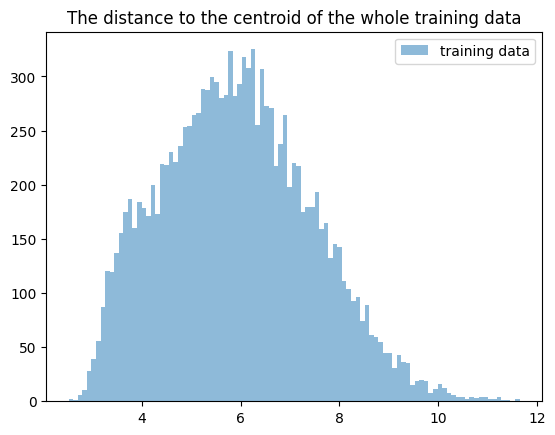

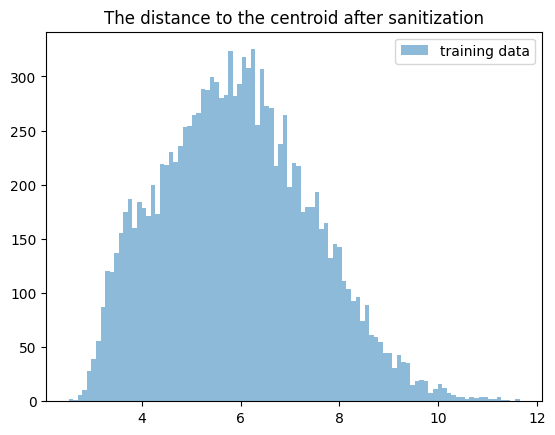

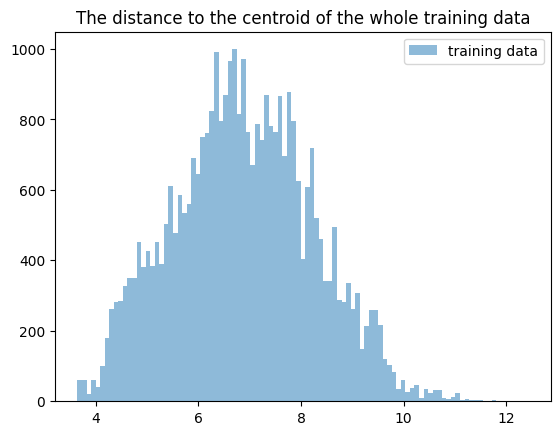

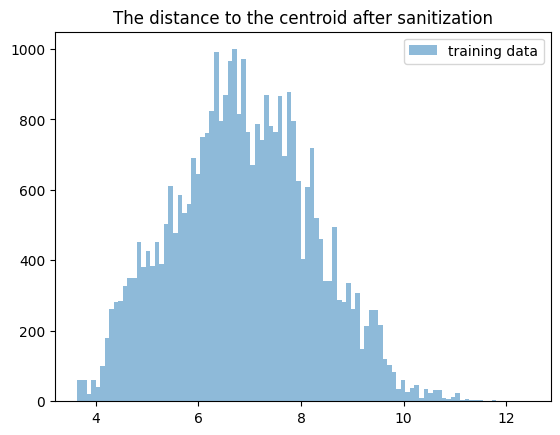

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test score on decoy theta:  (1.3081369244429388, 0.4294960702727693)
Decoy theta found!


  0%|          | 0/3 [00:00<?, ?it/s]

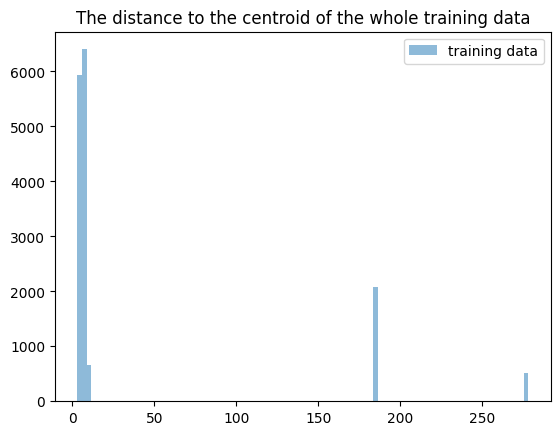

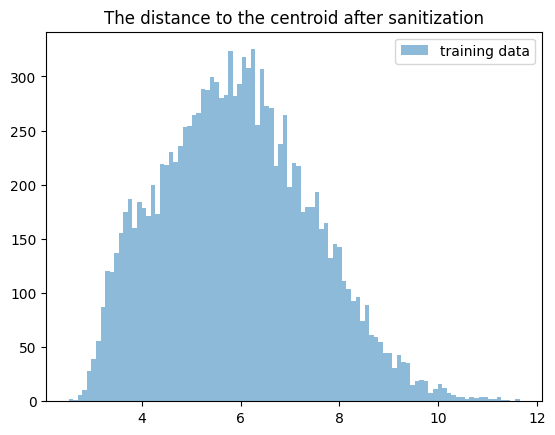

 33%|███▎      | 1/3 [00:02<00:04,  2.49s/it]

0.0169399645934291 0.04 0.16


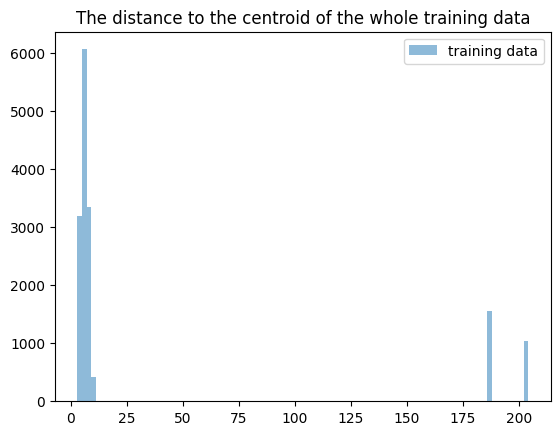

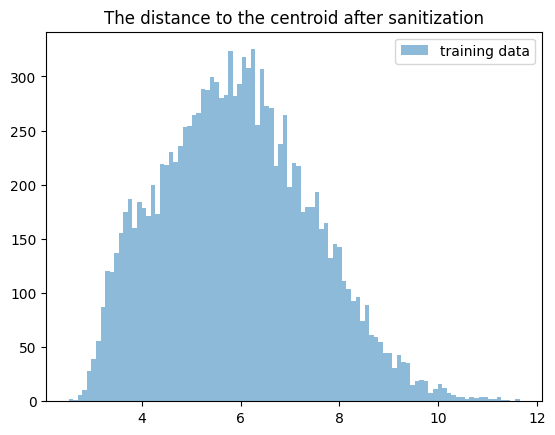

 67%|██████▋   | 2/3 [00:04<00:02,  2.14s/it]

0.0169399645934291 0.04 0.16


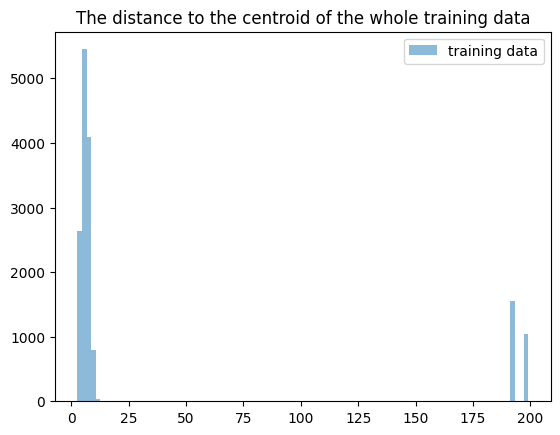

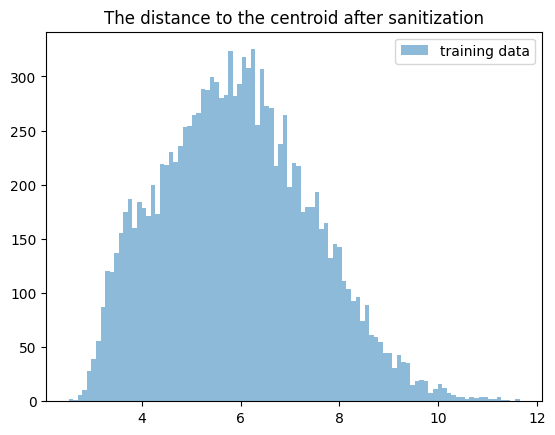

100%|██████████| 3/3 [00:06<00:00,  2.18s/it]

0.0169399645934291 0.04 0.16


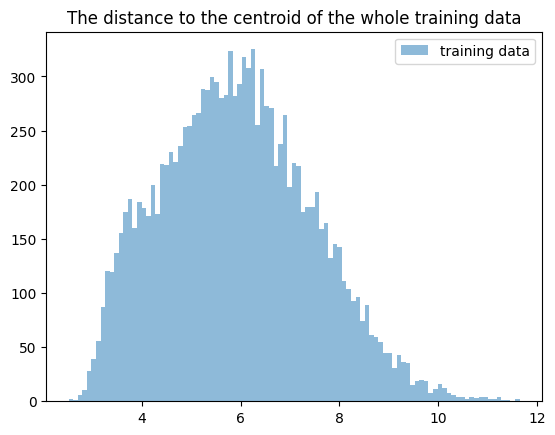

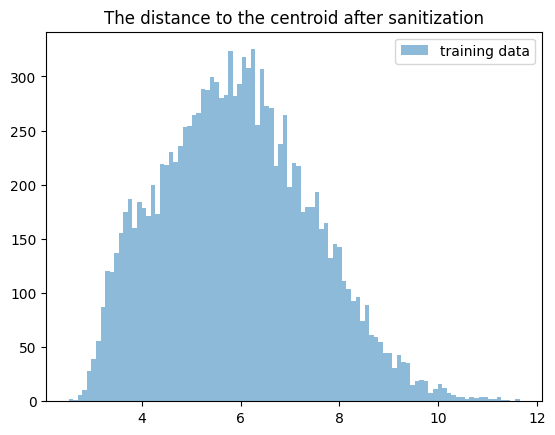


Avg loss of clean model: 0.01694, avg classification accuracy: 0.99260


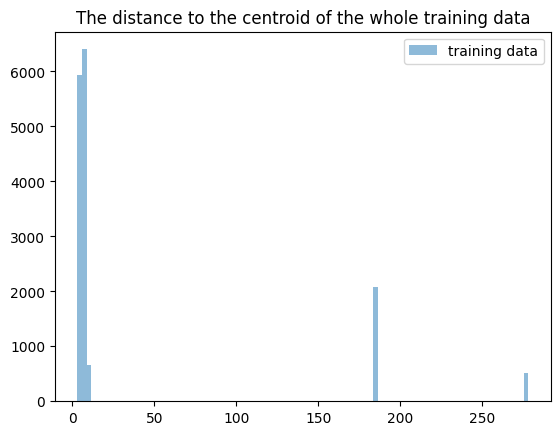

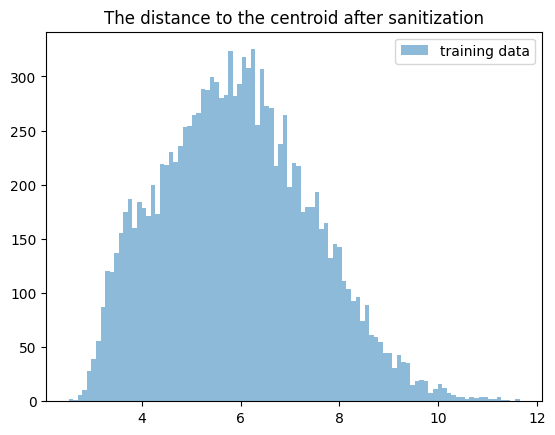


Avg loss of poisoned model:0.01694, avg classification accuracy: 0.99260


-----------result---------
KKT attack against data_sanitization svm model on mnist_17 dataset: 0.00 (0.20 fraction of poisoning data)


In [11]:
train_dataset,test_dataset = load_dataset('mnist_17')
base_model = load_model("svm", "mnist_17")
target_model = Data_Sanitized_Model(base_model,"svm", 0.2)
defense_name = 'data_sanitization'
fraction, attack_grade = compute_attack_grade("KKT", target_model, 0.2, train_dataset, test_dataset)
print('\n\n-----------result---------')
print('%s attack against %s %s model on %s dataset: %0.2f (%0.2f fraction of poisoning data)'%("KKT",defense_name,"svm","mnist_17",attack_grade,fraction))

# Report

**Q.1) Please describe your defense algorithm specifying how you filter out the poisoned data and why it is a good approach.**

My data sanitizationa approach is as follows:

1. Calculate the centroid of the whole training dataset $C$. I do this by taking the median of the dataset.
2. Calculate the distance of each point in the dataset from the centroid $D_{C,i}$.
3. There can be multiple points with the same centroid distance. Count the frequency of distances of each point. 
4. Select the points which have the 2 highest frequencies > 400.
5. Remove these 2 data points from the dataset.

This is a good approach because of the following reasons:

1. Looking at the distances of the whole poisoned dataset before sanitization, we can see that about ~13K points lie between 0-50 and that maximum number of points having the same distance from the centroid is < 400. Whereas on the extreme left end, we see 2 spikes of about ~1300 points --> These show that there are 1300 points that have the exact same distance from the centroid. 
$1300 >> 400$.

It is a very rare coincidence that so many images (~2600 in total) will have the same distance from the centroid of dataset. Therefore, we can assume strongly that these points were intelligently crafted as poisoned data. Therefore we remove them. 

<img src='task2-before-sanitization.png'/>

<img src='task2-after-sanitization.png'/>

2. This kind of data sanitization (based on frequency of distances rather than distance from the centroid) is still robust even if the poisoned points were within the clean data distribution.

**Note:**
1. We can also use data sanitization based on filterining points have large distance from the centroid or having non-zero loss (since optimal KKT has not been implemented).

<img src='task2-loss.png'/>



### Question 1: In the task, we assume that the defender can accurately estimate the contamination fraction of the training dataset. If the estimation is higher than the real contamination fraction, what would happen? What if the estimated contamination fraction is lower than the real fraction?

In my approach of data sanitization:

1. If the estimation is higher than the real contamination fraction, then my data sanitization fails. E.g., instead of 2600 estimated points, 100 points are poisoned. 100 < 400, therefore, all these points will still remain in my dataset. This will result in performance degradation. 

2. If the estimation is lower than the real contamination fraction, there would be no change in the performance since it would still satisfy my distance-frequency thresholds, e.g., instead of 2600 estimated points, 5000 points are poisoned. 5000 > 400, therefore, all these points will be removed. 


### Question 2. Compare the performance of the defense model in the adversarial setting (the test loss of the poisoned model) on different datasets. Does the defense have the same performance across all datasets? Why?

No, the defense does not have the same performance across all datasets. This is because of the following reasons:

1. It is possible that more than 400 clean points have the same distance from the centroid. In this case, all these clean points will also be removed along with the poisoned points. This can result in performance degradation (increased test loss). This property is extremely dependent on the dataset distribution. We will have to set a threshold (e.g., 400) looking ta each dataset distribution which may not always be easy.

2. It is possible that the dataset has less than 400 poisoned points with the same frequency-distance metrics. In this case, the dataset will still remain poisoned and the test loss will increase. 